In [1]:
import zhconv
import jieba
import pandas as pd
import transformers
import re
import esupar
from supar.utils.transform import CoNLLSentence
from itertools import combinations
import sys
import os
import logging
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

/Users/wayer/opt/anaconda3/envs/mnlpa1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

import hdbscan
from umap import UMAP
from sklearn.cluster import KMeans

/Users/wayer/opt/anaconda3/envs/mnlpa1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv('data/dataset.csv')

In [4]:
data.head()

,Unnamed: 0,book,chapter,content
0,0,analects,學而,子曰：「學而時習之，不亦說乎？有朋自遠方來，不亦樂乎？人不知而不慍，不亦君子乎？」\n\n有...
1,1,analects,為政,子曰：「為政以德，譬如北辰，居其所而眾星共之。」\n\n子曰：「詩三百，一言以蔽之，曰『思無...
2,2,analects,八佾,孔子謂季氏：「八佾舞於庭，是可忍也，孰不可忍也？」\n\n三家者以雍徹。子曰：「『相維辟公，...
3,3,analects,里仁,子曰：「里仁為美。擇不處仁，焉得知？」\n\n子曰：「不仁者不可以久處約，不可以長處樂。仁者...
4,4,analects,公冶長,子謂公冶長，「可妻也。雖在縲絏之中，非其罪也」。以其子妻之。\n\n子謂南容，「邦有道，不廢...


## Word segmentation

In [ ]:
nlp = esupar.load("KoichiYasuoka/roberta-classical-chinese-base-upos")
def word_segmentation(text):
    if not text or not isinstance(text, str):
        return ''
    conllu_data = nlp(text)
    word_segmented = conllu_data.values[1]
    word_segmented = ' '.join(word_segmented)
    return word_segmented

In [6]:
from zhconv import convert
# Convert the content to Simplified Chinese
data['chapter'] = data['chapter'].apply(lambda x: convert(x, 'zh-cn'))
data['content'] = data['content'].apply(lambda x: convert(x, 'zh-cn'))

# Create 'book', 'chapter', 'sentences' structure
data = data[['book', 'chapter', 'content']]

# Show the modified DataFrame
data.head()


,book,chapter,content
0,analects,学而,子曰：“学而时习之，不亦说乎？有朋自远方来，不亦乐乎？人不知而不愠，不亦君子乎？”\n\n有...
1,analects,为政,子曰：“为政以德，譬如北辰，居其所而众星共之。”\n\n子曰：“诗三百，一言以蔽之，曰‘思无...
2,analects,八佾,孔子谓季氏：“八佾舞于庭，是可忍也，孰不可忍也？”\n\n三家者以雍彻。子曰：“‘相维辟公，...
3,analects,里仁,子曰：“里仁为美。择不处仁，焉得知？”\n\n子曰：“不仁者不可以久处约，不可以长处乐。仁者...
4,analects,公冶长,子谓公冶长，“可妻也。虽在缧绁之中，非其罪也”。以其子妻之。\n\n子谓南容，“邦有道，不废...


In [ ]:
# 对'sentences'列应用word_segmentation函数，记录到一个txt文件中, 而且每一步都保存
with open('data/word_segmentation.txt', 'w', encoding='utf-8') as f:
    for sentence in data_sample['sentences']:
        seg_sentence = word_segmentation(sentence)
        f.write(seg_sentence + '\n')
        f.flush()  # 刷新文件内容到磁盘

In [9]:
# read output.txt file, and load it into the data dataframe, as a new column called 'segmented'
if os.path.exists('data/word_segmentation.txt'):
    with open('data/word_segmentation.txt', 'r') as f:
        lines = f.readlines()
    data['segmented'] = lines

## Add time attribute

In [12]:
list_bookname = list(data["book"].unique())
list_book_time = [
    ['analects',-480, -350],
    ['mengzi',  -340, -250],
    ['liji',    -475, -221],
    ['xunzi',   -475, -221],
    ['xiao-jing',-475, -221],
    ['shuo-yuan',-206, 9],
    ['chun-qiu-fan-lu',-206, 9],
    ['han-shi-wai-zhuan',-180, -120],
    ['da-dai-li-ji',100, 200],
    ['bai-hu-tong',79, 92],
    ['xin-shu', -206, 9],
    ['xin-xu',-206, 9],
    ['yangzi-fayan',-33, 18],
    ['zhong-lun',25, 220],
    ['kongzi-jiayu',-206, 220],
    ['qian-fu-lun',102, 167],
    ['lunheng', 80, 80],
    ['taixuanjing',-33, 18],
    ['fengsutongyi',190, 200],
    ['kongcongzi',25, 265],
    ['shenjian',196, 220],
    ['zhong-jing',100,166],
    ['su-shu',-250,-186],
    ['xinyu',-196, -196],
    ['duduan',167, 258],
    ['caizhong-langji', 152, 192]
]

In [13]:
data["average_year"] = None
num = list_bookname.index(data.iloc[0]["book"])
for i in range(data.shape[0]):
    num = list_bookname.index(data.iloc[i]["book"])
    list_book_time[num]
    data.loc[i, 'average_year'] = int((list_book_time[num][1]+list_book_time[num][2])/2)

In [14]:
# a function that maps the year in range 480bc (-480) to 258 to range 1677 to 2262, and able to map it back
def map_year(year):
    return int(year/2 + 2000)

def map_year_back(year):
    return int((year - 2000)*2)

data['mapped_year'] = data['average_year'].apply(map_year)

In [15]:
# Add a new column 'contain_ren' to check if the sentence contains the character '仁'
data['contain_ren'] = data['segmented'].apply(lambda x: 1 if '仁' in x else 0)

# Show the modified DataFrame
data.head()

,book,chapter,segmented,average_year,mapped_year,contain_ren
0,analects,学而,子 曰 学 而 时 习 之 不 亦 说 乎 有 朋 自 远 方 来 不 亦 乐 乎 人 不 ...,-415,1792,1
1,analects,为政,子 曰 为 政 以 德 譬 如 北 辰 居 其 所 而 众 星 共 之 子 曰 诗 三百 一...,-415,1792,0
2,analects,八佾,孔子 谓 季 氏 八 佾 舞 于 庭 是 可 忍 也 孰 不 可 忍 也 三 家 者 以 雍...,-415,1792,1
3,analects,里仁,子 曰 里 仁 为 美 择 不 处 仁 焉 得 知 子 曰 不 仁 者 不 可 以 久 处 ...,-415,1792,1
4,analects,公冶长,子 谓 公冶 长 可 妻 也 虽 在 缧 绁 之 中 非 其 罪 也 以 其 子 妻 之 子...,-415,1792,1


In [16]:
print(f'The length of the DataFrame is {len(data)}', 
      f'The number of sentences that contain the character "仁" is {len(data[data["contain_ren"] == 1])}', sep='\n')

The length of the DataFrame is 697
The number of sentences that contain the character "仁" is 346


In [17]:
# Create a new DataFrame 'ren_data' that contains only the sentences that contain the character '仁'
ren_data = data[data['contain_ren'] == 1].copy()

# drop the 'contain_ren' column
ren_data.drop('contain_ren', axis=1, inplace=True)
ren_data.reset_index(drop=True, inplace=True)

In [18]:
ren_data.head()

,book,chapter,segmented,average_year,mapped_year
0,analects,学而,子 曰 学 而 时 习 之 不 亦 说 乎 有 朋 自 远 方 来 不 亦 乐 乎 人 不 ...,-415,1792
1,analects,八佾,孔子 谓 季 氏 八 佾 舞 于 庭 是 可 忍 也 孰 不 可 忍 也 三 家 者 以 雍...,-415,1792
2,analects,里仁,子 曰 里 仁 为 美 择 不 处 仁 焉 得 知 子 曰 不 仁 者 不 可 以 久 处 ...,-415,1792
3,analects,公冶长,子 谓 公冶 长 可 妻 也 虽 在 缧 绁 之 中 非 其 罪 也 以 其 子 妻 之 子...,-415,1792
4,analects,雍也,子 曰 雍 也 可 使 南 面 仲弓 问 子桑 伯子 子 曰 可 也 简 仲弓 曰 居 敬 ...,-415,1792


In [19]:
ren_data['average_year'].unique()

array([-415, -295, -348, -98, -150, 150, 85, -7, 122, 7, 134, 80, 195,
       145, 208, 133, -218, -196, 212, 172], dtype=object)

In [20]:
ren_data['mapped_year'].unique()

array([1792, 1852, 1826, 1951, 1925, 2075, 2042, 1996, 2061, 2003, 2067,
       2040, 2097, 2072, 2104, 2066, 1891, 1902, 2106, 2086])

# Bertopic

In [31]:
data_set=[]

# store the sentences in the 'segmented' column to the data_set list
for sentence in ren_data['segmented']:
    data_set.append(sentence)
print(len(data_set))

346


In [41]:
# Generate word embedding vectors

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("Jihuai/bert-ancient-chinese")
model = AutoModel.from_pretrained("Jihuai/bert-ancient-chinese").to(device)

# 定义一个函数来分割长句子
def split_sentence(sentence, max_length=512):
    tokens = tokenizer.tokenize(sentence)
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    return [tokenizer.convert_tokens_to_string(chunk) for chunk in chunks]

# 定义一个函数来计算最大分块数
def compute_max_chunks(sentences, max_length=512):
    max_chunks = 0
    sentence_chunk_counts = []
    for sentence in sentences:
        chunks = split_sentence(sentence, max_length=max_length)
        chunk_count = len(chunks)
        sentence_chunk_counts.append(chunk_count)
        if chunk_count > max_chunks:
            max_chunks = chunk_count
    return max_chunks, sentence_chunk_counts

# 定义一个封装函数，使其行为类似于 sentence_model.encode
def encode_sentences(model, tokenizer, sentences, max_chunks, batch_size=32, max_length=512, show_progress_bar=False):
    all_embeddings = []
    sentence_chunk_counts = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        batch_embeddings = []
        for sentence in batch:
            chunks = split_sentence(sentence, max_length=max_length)
            sentence_chunk_counts.append(len(chunks))
            encoded_input = tokenizer(chunks, padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)
            with torch.no_grad():
                model_output = model(**encoded_input)
            sentence_embeddings = model_output.last_hidden_state.mean(dim=1)  # 平均池化
            batch_embeddings.append(sentence_embeddings)
        all_embeddings.extend(batch_embeddings)
        if show_progress_bar:
            print(f"Processed {i+batch_size}/{len(sentences)} sentences")
    
    # 扩展并拼接嵌入
    extended_embeddings = []
    for sentence_embeddings, chunk_count in zip(all_embeddings, sentence_chunk_counts):
        padding = torch.zeros((max_chunks - chunk_count, sentence_embeddings.shape[1])).to(device)
        extended_embedding = torch.cat([sentence_embeddings, padding], dim=0).flatten()
        extended_embeddings.append(extended_embedding)
    
    return torch.stack(extended_embeddings).cpu().numpy()

# 计算最大分块数
max_chunks, sentence_chunk_counts = compute_max_chunks(data_set, max_length=512)

# # 使用封装函数来生成嵌入
embeddings = encode_sentences(model, tokenizer, data_set, max_chunks, batch_size=32, max_length=512, show_progress_bar=True)

print(embeddings.shape)  # 输出的形状应为 (346, max_chunks * 768)

# # 保存嵌入
np.save('embeddings.npy', embeddings)

Using device: cuda


Some weights of BertModel were not initialized from the model checkpoint at Jihuai/bert-ancient-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed 32/346 sentences
Processed 64/346 sentences
Processed 96/346 sentences
Processed 128/346 sentences
Processed 160/346 sentences
Processed 192/346 sentences
Processed 224/346 sentences
Processed 256/346 sentences
Processed 288/346 sentences
Processed 320/346 sentences
Processed 352/346 sentences
(346, 16128)


In [23]:
# 从文件中加载嵌入
embeddings = np.load('data/embeddings.npy')

In [30]:
print(embeddings.shape, ren_data.shape)

(346, 16128) (346, 5)


In [25]:
# see unique years in timestamp
timestamp = ren_data['mapped_year'].tolist()
unique_years = list(set(timestamp))
print(unique_years)

[1792, 1925, 2061, 2066, 2067, 2072, 2075, 1951, 1826, 2086, 2097, 2104, 2106, 1852, 1996, 2003, 1891, 1902, 2040, 2042]


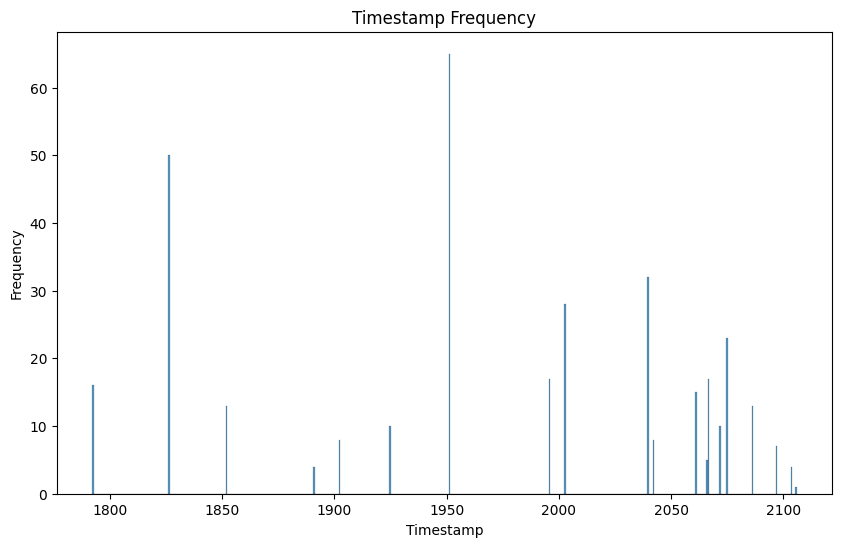

In [26]:
# 画出timestamp的frequency

plt.figure(figsize=(10, 6))
sns.histplot(timestamp, bins=500)
plt.title('Timestamp Frequency')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()

### Easy bertopic

In [32]:
#然后初始化CountVectorizer，在bertopic中计算tf-idf需要用到的，这时候要加载停用词，
#作者建议在聚类之后再使用停用词，因为句子embedding需要句子完整，如果一开始就去停用词，会导致embdding语义不完整
#所以在 CountVectorizer中才使用停用词，其实也就是不计算停用词对主题类的重要性
stop_word = [line.strip() for line in open('data/stop_word.txt','r',encoding='utf-8')]
vectorizer_model = CountVectorizer(stop_words=stop_word,analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")
#这里analyzer='word', token_pattern=u"(?u)\\b\\w+\\b" 的设置就是针对汉语的，因为汉语词既可以是单字词，又可以是多字词

# 训练模型
topic_model = BERTopic(language="multilingual", vectorizer_model=vectorizer_model, nr_topics='auto') #注意：这里有一些参数可以设置，最好查看源代码进行设置
topic = topic_model.fit(data_set, embeddings)
topic.get_topic_info() #还有很多其他的信息可以输出参考bertopic的github

,Topic,Count,Name,Representation,Representative_Docs
0,0,118,0_天_子_知_下,"[天, 子, 知, 下, 王, 道, 能, 行, 大, 言]",[天 命 之 谓 性 率 性 之 谓 道 修 道 之 谓 教 道 也 者 不 可 须臾 离 ...
1,1,60,1_子_天_行_道,"[子, 天, 行, 道, 礼, 仁, 民, 如, 君子, 此]",[孔子 曰 君子 之 道 譬 犹 防 与 夫 礼 之 塞 乱 之 所 从 生 也 ； 犹 防...
2,2,42,2_公_王_君_下,"[公, 王, 君, 下, 天, 子, 大, 臣, 国, 能]",[圣 人 之 于 天 下 百 姓 也 其 犹 赤 子 乎 饥 者 则 食 之 寒 者 则 衣...
3,3,40,3_能_言_行_孔子,"[能, 言, 行, 孔子, 然, 知, 善, 非, 君, 生]",[卫 将 军 文子 问 于 子贡 曰 吾 闻 孔子 之 施 教 也 先 之 以 《 诗 》 ...
4,4,34,4_天_王_大_能,"[天, 王, 大, 能, 孟子, 知, 生, 子, 礼, 与]",[孟子 曰 尽 其 心 者 知 其 性 也 知 其 性 则 知 天 矣 存 其 心 养 其 ...
5,5,28,5_测_仁_君子_次,"[测, 仁, 君子, 次, 忠, 道, 行, 子, 大, 天]",[子 曰 学 而 时 习 之 不 亦 说 乎 有 朋 自 远 方 来 不 亦 乐 乎 人 不...
6,6,24,6_王_子_君_天,"[王, 子, 君, 天, 下, 公, 臣, 国, 言, 大]",[鲁 哀 公 问 子夏 曰 必 学 而 后 可 以 安 国 保 民 乎 子夏 曰 不 学 而...


In [33]:
topic_model.visualize_topics()

In [26]:
topics_over_time = topic_model.topics_over_time(data_set, timestamp, global_tuning=True, 
                                                evolution_tuning=True, nr_bins=20, datetime_format="%Y")
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=[0, 7])

### finetuning bertopic

In [34]:
# # 初步使用 KMeans 聚类
# kmeans = KMeans(n_clusters=20, random_state=42)
# kmeans_labels = kmeans.fit_predict(embeddings)

# 使用调整后的 UMAP 和 HDBSCAN
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, cluster_selection_method='eom', prediction_data=True)

# 创建 BERTopic 模型
stop_word = [line.strip() for line in open('data/stop_word.txt','r',encoding='utf-8')]
vectorizer_model = CountVectorizer(stop_words=stop_word,analyzer='word', token_pattern=u"(?u)\\b\\w+\\b", min_df=3)
topic_model3 = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, language="multilingual", vectorizer_model=vectorizer_model, top_n_words=30, nr_topics="auto" )

topic = topic_model3.fit(data_set, embeddings)
topic_info = topic.get_topic_info() #还有很多其他的信息可以输出参考bertopic的github

# 获取主题信息
topic_info = topic_model3.get_topic_info()

# 打印主题信息
topic.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,75,0_王_天_公_子,"[王, 天, 公, 子, 下, 君, 国, 能, 大, 臣, 知, 言, 得, 与, 行, ...",[齐 宣 王 谓 田 过 曰 吾 闻 儒 者 亲 丧 三 年 君 与 父 孰 重 过 对 曰...
1,1,65,1_孔子_民_天_子,"[孔子, 民, 天, 子, 此, 行, 言, 知, 问, 仁, 道, 如, 德, 君子, 礼...",[公 曰 四 代 之 政 刑 论 其 明 者 可 以 为 法 乎 子 曰 何 哉 四 代 之...
2,2,60,2_子_天_行_道,"[子, 天, 行, 道, 礼, 仁, 民, 如, 君子, 此, 必, 德, 事, 知, 与,...",[颜 渊 问 仁 子 曰 克 己 复 礼 为 仁 一 日 克 己 复 礼 天 下 归 仁 焉...
3,3,40,3_能_言_行_孔子,"[能, 言, 行, 孔子, 然, 善, 知, 非, 君, 生, 君子, 此, 见, 天, 子...",[卫 将 军 文子 问 于 子贡 曰 吾 闻 孔子 之 施 教 也 先 之 以 《 诗 》 ...
4,4,34,4_天_王_大_能,"[天, 王, 大, 能, 孟子, 生, 知, 礼, 子, 与, 言, 行, 然, 事, 下,...",[孟子 曰 天 时 不 如 地 利 地 利 不 如 人 和 三 里 之 城 七 里 之 郭 ...
5,5,30,5_天_子_大_下,"[天, 子, 大, 下, 义, 君, 王, 知, 道, 与, 然, 礼, 非, 能, 此, ...",[殷 为 天 子 三十 余 世 而 周 受 之 ； 周 为 天 子 三十 余 世 而 秦 受...
6,6,28,6_测_仁_次_君子,"[测, 仁, 次, 君子, 忠, 道, 行, 大, 子, 天, 同, 得, 一, 德, 能,...",[子 曰 学 而 时 习 之 不 亦 说 乎 有 朋 自 远 方 来 不 亦 乐 乎 人 不...
7,7,14,7_王_君_子_天,"[王, 君, 子, 天, 下, 公, 臣, 行, 言, 国, 民, 侯, 大, 能, 得, ...",[人 君 之 欲 平 治 天 下 而 垂 荣 名 者 必 尊 贤 而 下 士 《 易 》 曰...


In [31]:
topic_model3.save("bertopic_model.pkl")

2024-05-25 00:24:52,803 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
